In [1]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])


In [2]:
df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,20,5,Never-married,Machine-op-inspct,Own-child,Female,0,0,11,<=50K
1,52,14,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,45,<=50K.
2,38,12,Never-married,Exec-managerial,Not-in-family,Male,0,0,60,<=50K
4,47,9,Married-civ-spouse,Farming-fishing,Husband,Male,2829,0,65,<=50K
5,50,10,Married-civ-spouse,Adm-clerical,Husband,Male,0,1740,48,<=50K
...,...,...,...,...,...,...,...,...,...,...
48837,44,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,48,>50K
48838,51,15,Never-married,Prof-specialty,Not-in-family,Female,0,2559,50,>50K
48839,33,9,Married-civ-spouse,Protective-serv,Husband,Male,0,0,32,<=50K.
48840,46,14,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,40,>50K


In [3]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)





df["Income"] = df["Income"].map(income_mapping_dict)
df


,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,0,5,Never-married,1,Own-child,1,0,0,11,0
1,4,14,Married-civ-spouse,1,Husband,0,0,0,45,0
2,2,12,Never-married,0,Not-in-family,0,0,0,60,0
4,3,9,Married-civ-spouse,1,Husband,0,2829,0,65,0
5,3,10,Married-civ-spouse,0,Husband,0,0,1740,48,0
...,...,...,...,...,...,...,...,...,...,...
48837,3,13,Married-civ-spouse,0,Husband,0,0,0,48,1
48838,4,15,Never-married,0,Not-in-family,1,0,2559,50,1
48839,2,9,Married-civ-spouse,1,Husband,0,0,0,32,0
48840,3,14,Married-civ-spouse,0,Husband,0,0,0,40,1


In [4]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

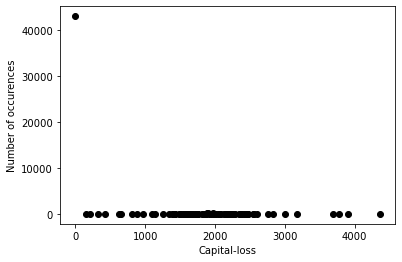

In [5]:
# Visualizing before feature scaling
df['Capital-loss'].value_counts().values
df['Capital-loss'].value_counts().index.tolist()

# Plotting the number of occurences of each age within the data
plt.scatter(df['Capital-loss'].value_counts().index.tolist(), df['Capital-loss'].value_counts().values, color='black')
plt.xlabel("Capital-loss")
plt.ylabel("Number of occurences")
plt.show()

In [6]:
# Will now test different feature scaling on Capital-gain and Capital-loss
col_names = ['Capital-gain', 'Capital-loss']
features = df[col_names]

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
scaler = Normalizer(norm = 'l2')
# scaler = QuantileTransformer()
# scaler = RobustScaler()
# scaler = MaxAbsScaler()
# scaler = StandardScaler()
# scaler = MinMaxScaler()
df[col_names] = scaler.fit_transform(features.values)
df


,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,0,5,1,1,0.0,0.0,11,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,4,14,1,0,0.0,0.0,45,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2,12,0,0,0.0,0.0,60,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3,9,1,0,1.0,0.0,65,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,3,10,0,0,0.0,1.0,48,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,3,13,0,0,0.0,0.0,48,1,1,0,...,0,0,0,0,0,1,0,0,0,0
48838,4,15,0,1,0.0,1.0,50,1,0,1,...,0,0,0,0,0,0,0,1,0,0
48839,2,9,1,0,0.0,0.0,32,0,1,0,...,0,0,0,0,0,1,0,0,0,0
48840,3,14,0,0,0.0,0.0,40,1,1,0,...,0,0,0,0,0,1,0,0,0,0


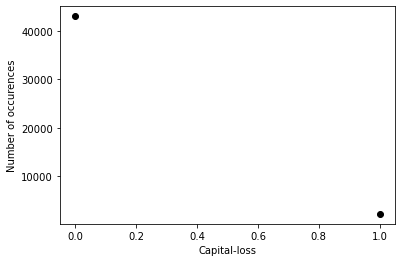

In [7]:
# Visualizing after feature scaling

df['Capital-loss'].value_counts().values
df['Capital-loss'].value_counts().index.tolist()

# Plotting the number of occurences of each age within the data
plt.scatter(df['Capital-loss'].value_counts().index.tolist(), df['Capital-loss'].value_counts().values, color='black')
plt.xlabel("Capital-loss")
plt.ylabel("Number of occurences")
plt.show()

In [8]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [10]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Classifier
model=RandomForestClassifier(n_estimators=100)


# Use cross-validation
from sklearn.model_selection import cross_val_predict
# Use 3-fold cross-validation
train_data_predictions = cross_val_predict(model, X_train, y_train.ravel(), cv=3)

from sklearn.metrics import confusion_matrix
# Show confusion matrix for our classifier’s predictions
confusion_matrix(y_train, train_data_predictions)


array([[24701,  2540],
       [ 3801,  5135]])

In [11]:
from sklearn.metrics import precision_score, recall_score

# Calculate and print precision and recall as percentages
print("Precision: " + str(round(precision_score(y_train, train_data_predictions)*100,1))+"%")
print("Recall: " + str(round(recall_score(y_train, train_data_predictions)*100,1))+"%")

Precision: 66.9%
Recall: 57.5%


In [12]:
# Use cross_val_predict to get our model's decision scores for each digit it has predicted
train_data_decision_scores = cross_val_predict(sgd_clf_7, X_train, y_train.ravel(), cv=3)

from sklearn.metrics import precision_recall_curve

# Obtain possible combinations of precisions, recalls, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, train_data_decision_scores)

In [13]:
# Finding F1 score

from sklearn.metrics import f1_score

# Obtain and print F1 score as a percentage
print("F1 score: " + str(round(f1_score(y_train, train_data_predictions)*100,1))+"%")

F1 score: 61.8%


<ipython-input-26-089b9ba89319>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
<ipython-input-26-089b9ba89319>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])


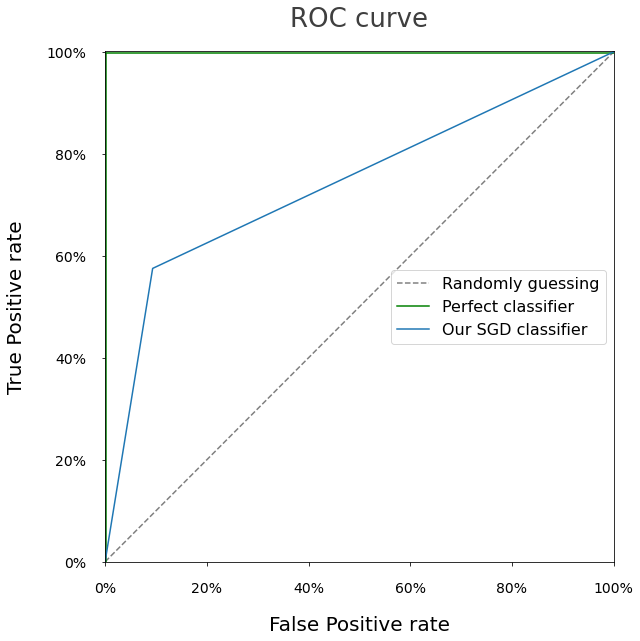

In [26]:
# Plot ROC curve

from sklearn.metrics import roc_curve


fig, ax = plt.subplots(figsize=(9,9))
ax.grid(False)
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)
# Plot random guess classifier
ax.plot([0,1], [0,1], "k--", alpha=0.5, label="Randomly guessing") 
# Plot perfect classifier
ax.plot([0.002,0.002], [0,0.998], "green", label="Perfect classifier")
ax.plot([0.001,1], [0.998,0.998], "green")

# Obtain possible combinations of true/false positive rates and thresholds
fpr, tpr, thresholds = roc_curve(y_train, train_data_decision_scores)

# Plot our classifier
ax.plot(fpr, tpr, label="Our SGD classifier")

# Set x- and y-axis limits
ax.axis([-0.001,1.001,-0.001,1.001])

# Add legend
ax.legend(loc="center right", fontsize=16)

# Set labels
ax.set_xlabel("False Positive rate", labelpad=20, fontsize=20)
ax.set_ylabel("True Positive rate", labelpad=20, fontsize=20)

# show percentages rather than decimals
x_vals = ax.get_xticks()
y_vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])

# Add title
ax.text(x = 0.5, y = 1.05, s = "ROC curve", fontsize = 26, alpha = .75, ha="center")

plt.tight_layout()


In [15]:
# Obtaining AUC value

from sklearn.metrics import roc_auc_score

# Obtain and print AUC
print("Area Under Curve (AUC): " + str(round(roc_auc_score(y_train, train_data_predictions),3)))



Area Under Curve (AUC): 0.741


In [17]:
# With ['Age', 'Education', 'Occupation', 'Race', 'Sex', 'Hours-per-week', 'Native-country']:
# Area Under Curve (AUC): 0.687
# F1 score: 53.4%
# Precision: 61.4%
# Recall: 47.2%
# Confusion matrix:
# array([[24582,  2656],
#        [ 4719,  4220]])

In [18]:
# With new features determined from correlation heatmap (NO FEATURE SCALING)
# Area Under Curve (AUC): 0.765
# F1 score: 65.6%
# Precision: 70.2%
# Recall: 61.5%
# Confusion matrix:
# array([[24849,  2348],
#        [ 3454,  5526]])

In [19]:
# With new features determined from correlation heatmap (MINMAX SCALING)
# Area Under Curve (AUC): 0.762
# F1 score: 65.2%
# Precision: 69.8%
# Recall: 61.1%
# Confusion matrix:
# array([[24782,  2382],
#        [ 3504,  5509]])

# Therefore, performed worse than without feature scaling

In [20]:
# With new features determined from correlation heatmap (Standard SCALING)
# Area Under Curve (AUC): 0.769
# F1 score: 66.2%
# Precision: 70.5%
# Recall: 62.4%
# Confusion matrix:
# array([[24864,  2340],
#        [ 3377,  5596]])

# Therefore, performed better than without feature scaling

In [21]:
# With new features determined from correlation heatmap (MaxAbs SCALING)
# Area Under Curve (AUC): 0.764
# F1 score: 65.5%
# Precision: 69.6%
# Recall: 61.8%
# Confusion matrix:
# array([[24731,  2434],
#        [ 3444,  5568]])

# Therefore, performed worse than Standard scaling

In [16]:
# Robust not as well
# Quantile transformer not as well
# Normalizer not as well




# https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

In [ ]:
# Therefore, standard scaling performs best